In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score, confusion_matrix,
                             ConfusionMatrixDisplay, roc_curve, classification_report)
import joblib

In [2]:
# === Load Dataset ===
df = pd.read_csv("train_subset.csv")
df.drop(columns='id', inplace=True)
df['age_years'] = (df['age'] / 365).astype(int)
df.drop(columns='age', inplace=True)
df.replace({'Yes': 1, 'No': 0}, inplace=True)

C:\Users\hp\AppData\Local\Temp\ipykernel_34656\3925614510.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({'Yes': 1, 'No': 0}, inplace=True)


In [3]:
# === Feature Selection (Chi2 + Semantic Deduplication) ===
target_col = "cardio"
X = df.drop(columns=target_col)
y = df[target_col]

cols_to_encode = ['gender', 'cholesterol', 'gluc']
X = pd.get_dummies(X, columns=cols_to_encode, prefix=cols_to_encode, drop_first=False)

X_scaled_chi2 = MinMaxScaler().fit_transform(X)
selector = SelectKBest(score_func=chi2, k='all')
selector.fit(X_scaled_chi2, y)
chi_scores = pd.Series(selector.scores_, index=X.columns)

semantic_groups = {
    'cholesterol': ['cholesterol_1', 'cholesterol_2', 'cholesterol_3'],
    'gluc': ['gluc_1', 'gluc_2', 'gluc_3'],
    'gender': ['gender_1', 'gender_2'],
    'age_years': ['age_years'],
    'weight': ['weight'],
    'height': ['height'],
    'ap_hi': ['ap_hi'],
    'ap_lo': ['ap_lo'],
    'smoke': ['smoke'],
    'alco': ['alco'],
    'active': ['active']
}

representative_features = []
for group, cols in semantic_groups.items():
    best_col = max((col for col in cols if col in chi_scores), key=lambda c: chi_scores[c], default=None)
    if best_col:
        representative_features.append((group, best_col, chi_scores[best_col]))

selected_features = [t[1] for t in sorted(representative_features, key=lambda x: x[2], reverse=True)[:10]]
X_selected = X[selected_features]

In [21]:
print(selected_features)

['cholesterol_3', 'gluc_3', 'age_years', 'weight', 'smoke', 'active', 'ap_lo', 'alco', 'gender_2', 'ap_hi']


In [4]:
# === Split Data ===
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

In [5]:
# === Scale Features ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

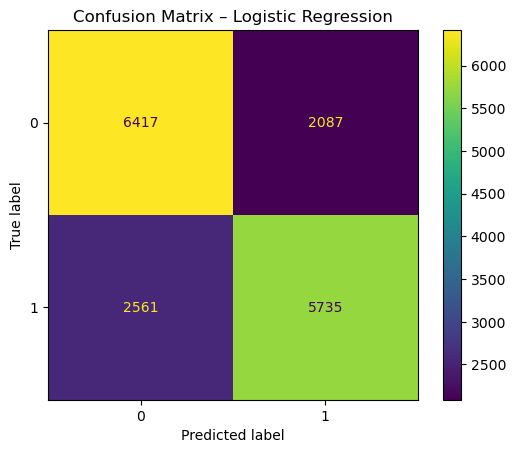

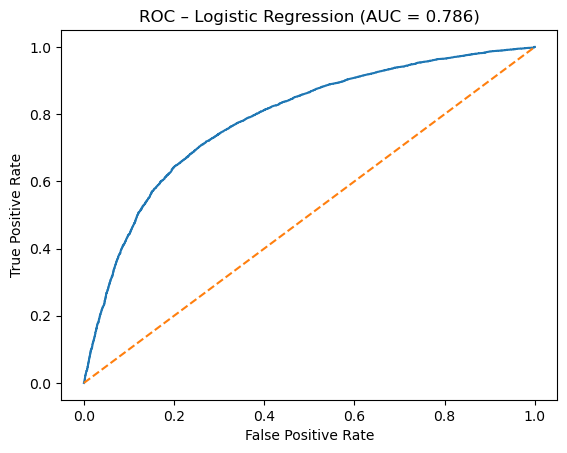

In [6]:
# %% Logistic Regression
log_reg = LogisticRegression(solver="liblinear", random_state=42)
log_reg.fit(X_train_scaled, y_train)

y_pred_lr   = log_reg.predict(X_test_scaled)
y_proba_lr  = log_reg.predict_proba(X_test_scaled)[:, 1]

# Metrics
acc_lr  = accuracy_score(y_test, y_pred_lr)
f1_lr   = f1_score(y_test, y_pred_lr)
auc_lr  = roc_auc_score(y_test, y_proba_lr)

# Plots
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr)
plt.title("Confusion Matrix – Logistic Regression")
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_proba_lr)
plt.plot(fpr, tpr); plt.plot([0,1],[0,1],"--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title(f"ROC – Logistic Regression (AUC = {auc_lr:.3f})")
plt.show()

# Store results
results = [{"Model":"Logistic Regression","Accuracy":acc_lr,"F1":f1_lr,"ROC AUC":auc_lr,"Estimator":log_reg}]

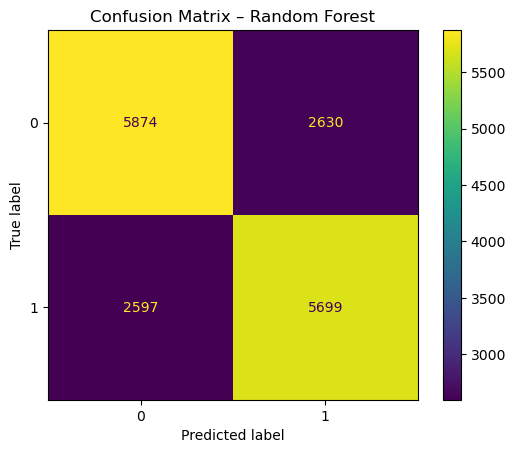

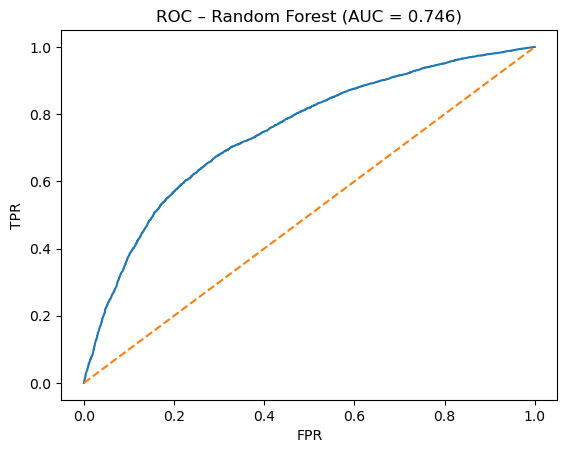

In [7]:
# %% Random Forest
rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train_scaled, y_train)

y_pred_rf  = rf.predict(X_test_scaled)
y_proba_rf = rf.predict_proba(X_test_scaled)[:,1]

acc_rf = accuracy_score(y_test, y_pred_rf)
f1_rf  = f1_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_proba_rf)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf)
plt.title("Confusion Matrix – Random Forest"); plt.show()

fpr, tpr, _ = roc_curve(y_test, y_proba_rf)
plt.plot(fpr, tpr); plt.plot([0,1],[0,1],"--")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title(f"ROC – Random Forest (AUC = {auc_rf:.3f})"); plt.show()

results.append({"Model":"Random Forest","Accuracy":acc_rf,"F1":f1_rf,"ROC AUC":auc_rf,"Estimator":rf})


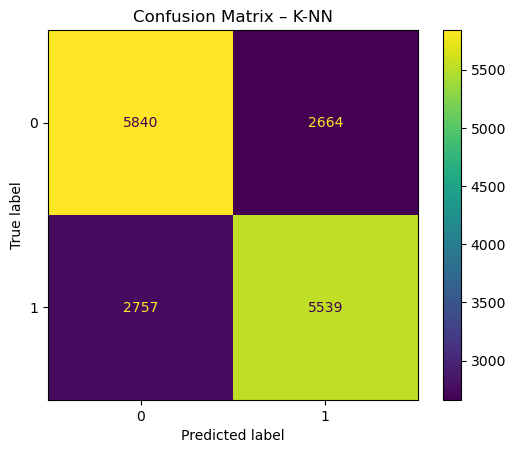

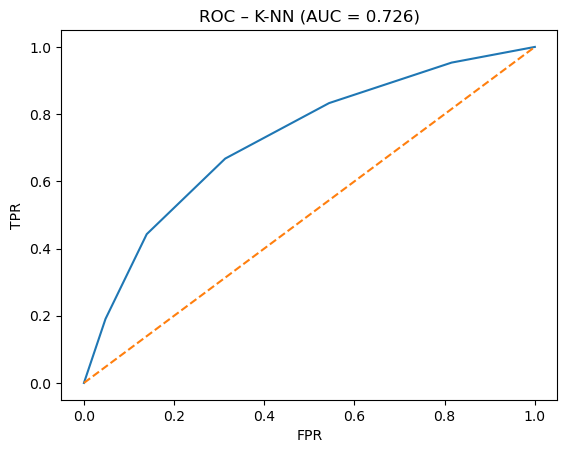

In [8]:
# %% K-NN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

y_pred_knn  = knn.predict(X_test_scaled)
y_proba_knn = knn.predict_proba(X_test_scaled)[:,1]

acc_knn = accuracy_score(y_test, y_pred_knn)
f1_knn  = f1_score(y_test, y_pred_knn)
auc_knn = roc_auc_score(y_test, y_proba_knn)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_knn)
plt.title("Confusion Matrix – K-NN"); plt.show()

fpr, tpr, _ = roc_curve(y_test, y_proba_knn)
plt.plot(fpr, tpr); plt.plot([0,1],[0,1],"--")
plt.title(f"ROC – K-NN (AUC = {auc_knn:.3f})"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.show()

results.append({"Model":"K-NN","Accuracy":acc_knn,"F1":f1_knn,"ROC AUC":auc_knn,"Estimator":knn})

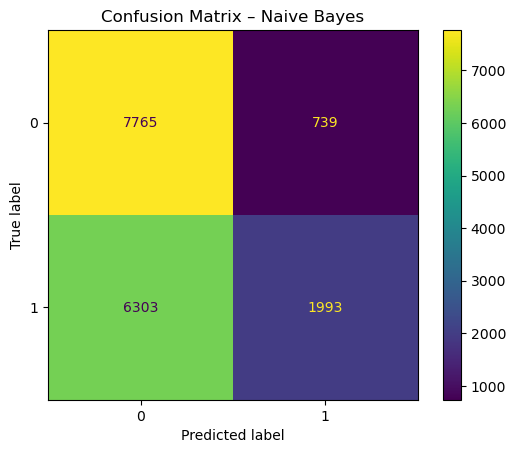

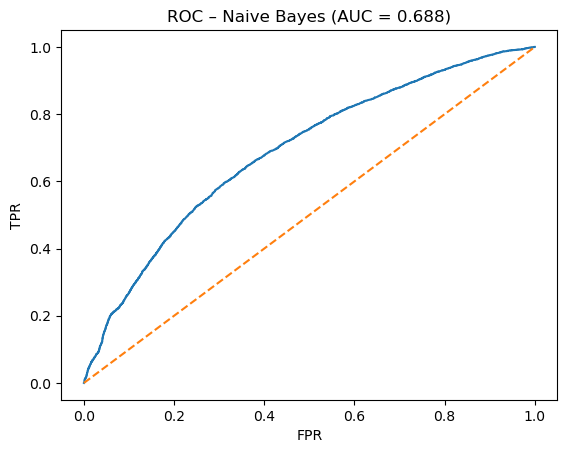

In [9]:
# %% Naive Bayes
nb = GaussianNB()
nb.fit(X_train_scaled, y_train)

y_pred_nb  = nb.predict(X_test_scaled)
y_proba_nb = nb.predict_proba(X_test_scaled)[:,1]

acc_nb = accuracy_score(y_test, y_pred_nb)
f1_nb  = f1_score(y_test, y_pred_nb)
auc_nb = roc_auc_score(y_test, y_proba_nb)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_nb)
plt.title("Confusion Matrix – Naive Bayes"); plt.show()

fpr, tpr, _ = roc_curve(y_test, y_proba_nb)
plt.plot(fpr, tpr); plt.plot([0,1],[0,1],"--")
plt.title(f"ROC – Naive Bayes (AUC = {auc_nb:.3f})"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.show()

results.append({"Model":"Naive Bayes","Accuracy":acc_nb,"F1":f1_nb,"ROC AUC":auc_nb,"Estimator":nb})

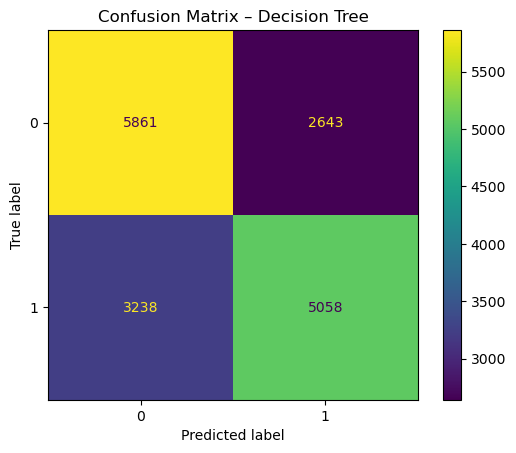

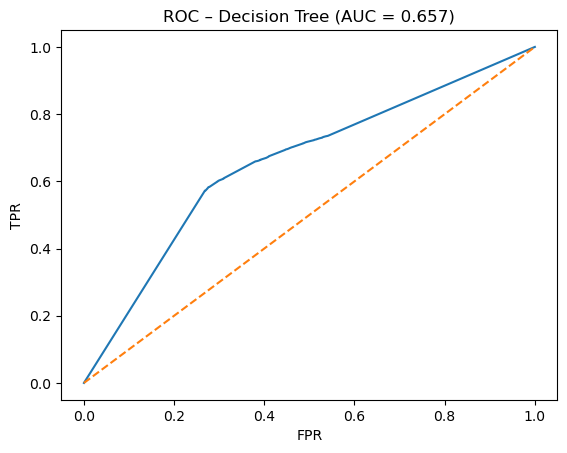

In [10]:
# %% Decision Tree (Entropy)
dt = DecisionTreeClassifier(criterion="entropy", random_state=42)
dt.fit(X_train_scaled, y_train)

y_pred_dt  = dt.predict(X_test_scaled)
y_proba_dt = dt.predict_proba(X_test_scaled)[:,1]

acc_dt = accuracy_score(y_test, y_pred_dt)
f1_dt  = f1_score(y_test, y_pred_dt)
auc_dt = roc_auc_score(y_test, y_proba_dt)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_dt)
plt.title("Confusion Matrix – Decision Tree"); plt.show()

fpr, tpr, _ = roc_curve(y_test, y_proba_dt)
plt.plot(fpr, tpr); plt.plot([0,1],[0,1],"--")
plt.title(f"ROC – Decision Tree (AUC = {auc_dt:.3f})"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.show()

results.append({"Model":"Decision Tree","Accuracy":acc_dt,"F1":f1_dt,"ROC AUC":auc_dt,"Estimator":dt})

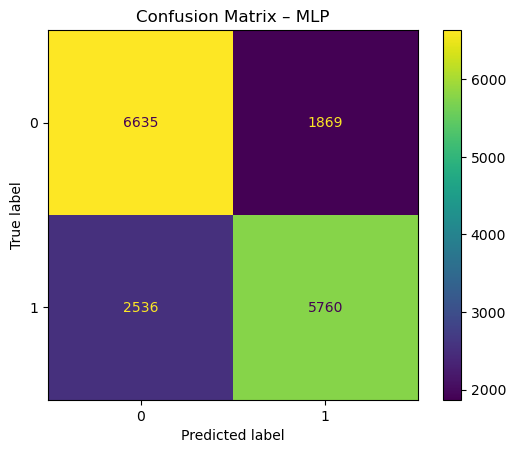

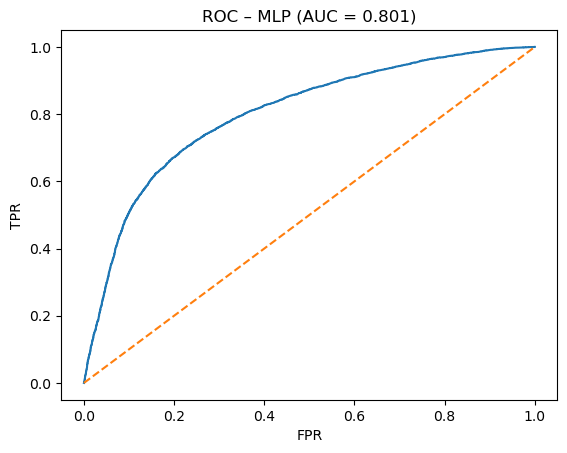

In [11]:
# %% MLP (Neural Network)
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
mlp.fit(X_train_scaled, y_train)

y_pred_mlp  = mlp.predict(X_test_scaled)
y_proba_mlp = mlp.predict_proba(X_test_scaled)[:,1]

acc_mlp = accuracy_score(y_test, y_pred_mlp)
f1_mlp  = f1_score(y_test, y_pred_mlp)
auc_mlp = roc_auc_score(y_test, y_proba_mlp)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_mlp)
plt.title("Confusion Matrix – MLP"); plt.show()

fpr, tpr, _ = roc_curve(y_test, y_proba_mlp)
plt.plot(fpr, tpr); plt.plot([0,1],[0,1],"--")
plt.title(f"ROC – MLP (AUC = {auc_mlp:.3f})"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.show()

results.append({"Model":"MLP","Accuracy":acc_mlp,"F1":f1_mlp,"ROC AUC":auc_mlp,"Estimator":mlp})

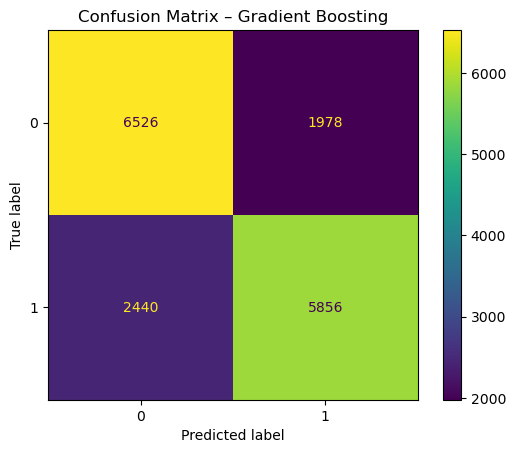

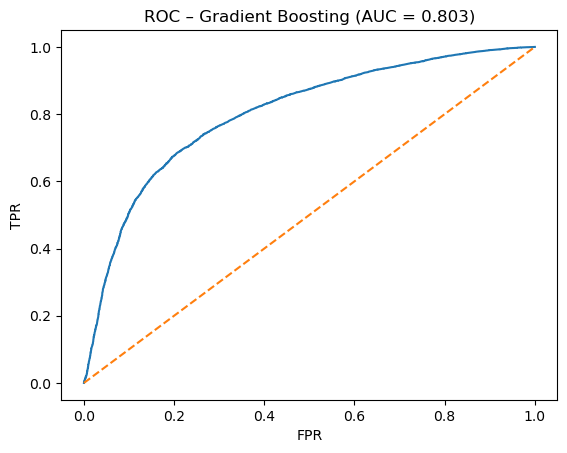

In [12]:
# %% Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train_scaled, y_train)

y_pred_gb  = gb.predict(X_test_scaled)
y_proba_gb = gb.predict_proba(X_test_scaled)[:,1]

acc_gb = accuracy_score(y_test, y_pred_gb)
f1_gb  = f1_score(y_test, y_pred_gb)
auc_gb = roc_auc_score(y_test, y_proba_gb)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_gb)
plt.title("Confusion Matrix – Gradient Boosting"); plt.show()

fpr, tpr, _ = roc_curve(y_test, y_proba_gb)
plt.plot(fpr, tpr); plt.plot([0,1],[0,1],"--")
plt.title(f"ROC – Gradient Boosting (AUC = {auc_gb:.3f})"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.show()

results.append({"Model":"Gradient Boosting","Accuracy":acc_gb,"F1":f1_gb,"ROC AUC":auc_gb,"Estimator":gb})

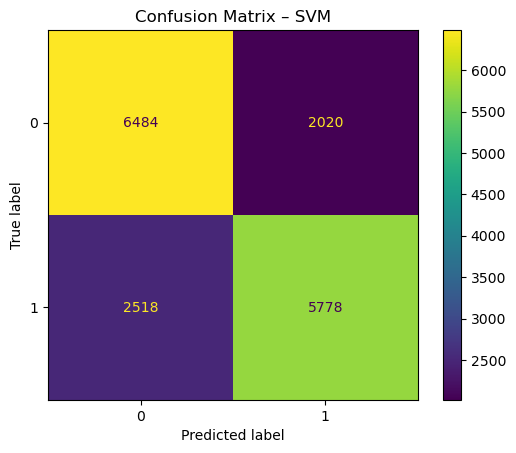

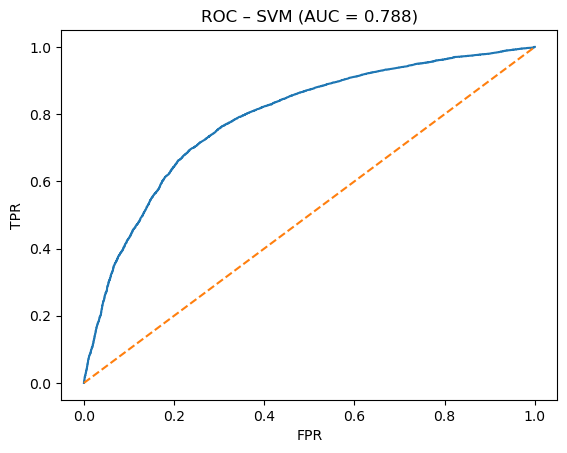

In [13]:
# %% Support Vector Machine
svm = SVC(kernel="rbf", probability=True, random_state=42)
svm.fit(X_train_scaled, y_train)

y_pred_svm  = svm.predict(X_test_scaled)
y_proba_svm = svm.predict_proba(X_test_scaled)[:,1]

acc_svm = accuracy_score(y_test, y_pred_svm)
f1_svm  = f1_score(y_test, y_pred_svm)
auc_svm = roc_auc_score(y_test, y_proba_svm)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm)
plt.title("Confusion Matrix – SVM"); plt.show()

fpr, tpr, _ = roc_curve(y_test, y_proba_svm)
plt.plot(fpr, tpr); plt.plot([0,1],[0,1],"--")
plt.title(f"ROC – SVM (AUC = {auc_svm:.3f})"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.show()

results.append({"Model":"SVM","Accuracy":acc_svm,"F1":f1_svm,"ROC AUC":auc_svm,"Estimator":svm})


In [14]:
# %% Summary table & save best model
summary_df = pd.DataFrame(results).drop(columns="Estimator")
display(summary_df.style.format({"Accuracy":"{:.3f}","F1":"{:.3f}","ROC AUC":"{:.3f}"}))

# Identify the best by ROC AUC (change to Accuracy/F1 if preferred)
best_idx = summary_df["ROC AUC"].idxmax()
best_row = results[best_idx]
best_model = best_row["Estimator"]
best_name  = best_row["Model"]

print(f"\n Best model by ROC AUC: {best_name} (AUC = {best_row['ROC AUC']:.3f})")

,Model,Accuracy,F1,ROC AUC
0,Logistic Regression,0.723,0.712,0.786
1,Random Forest,0.689,0.686,0.746
2,K-NN,0.677,0.671,0.726
3,Naive Bayes,0.581,0.361,0.688
4,Decision Tree,0.650,0.632,0.657
5,MLP,0.738,0.723,0.801
6,Gradient Boosting,0.737,0.726,0.803
7,SVM,0.730,0.718,0.788



 Best model by ROC AUC: Gradient Boosting (AUC = 0.803)


In [ ]:
# === Hyperparameter Tuning ===
if best_name == "MLP":
    param_grid = {
        'hidden_layer_sizes': [(100,), (100, 50), (50, 25)],
        'activation': ['relu', 'tanh', 'logistic'],
        'solver': ['adam', 'lbfgs'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive']
    }
    search_model = MLPClassifier(max_iter=500, random_state=42, early_stopping=True)

elif best_name == "Gradient Boosting":
    param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.0001, 0.001, 0.01, 0.1],
        'max_depth': [3, 5]
    }
    search_model = GradientBoostingClassifier(random_state=42)

else:
    print(f"Hyperparameter tuning not defined for {best_name}. Skipping tuning.")
    search_model = None

Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.77      0.75      8504
           1       0.75      0.71      0.73      8296

    accuracy                           0.74     16800
   macro avg       0.74      0.74      0.74     16800
weighted avg       0.74      0.74      0.74     16800



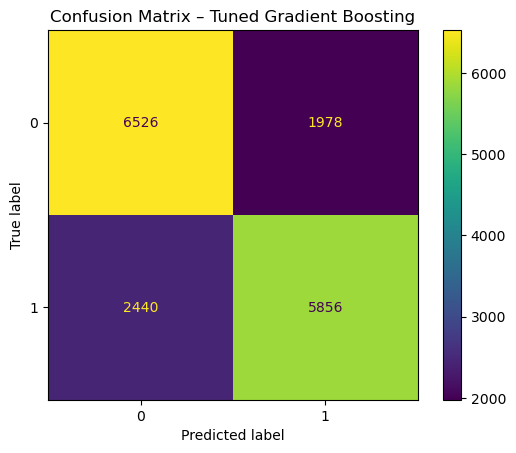

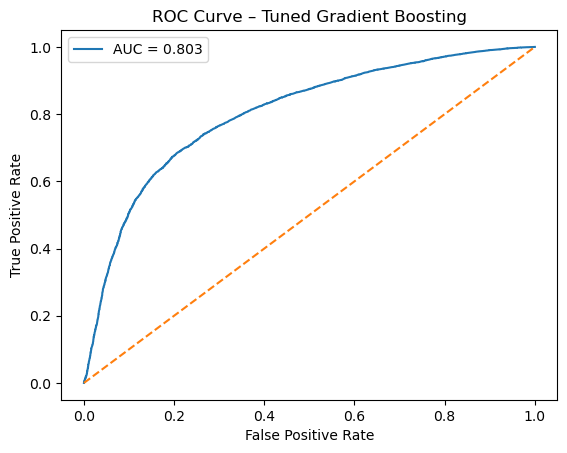


Tuned model saved: best_model_tuned_Gradient_Boosting.pkl


In [25]:
# === Grid Search and Evaluation ===
if search_model is not None:
    grid_search = GridSearchCV(search_model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)
    grid_search.fit(X_train_scaled, y_train)
    best_tuned_model = grid_search.best_estimator_
    y_pred_tuned = best_tuned_model.predict(X_test_scaled)
    y_proba_tuned = best_tuned_model.predict_proba(X_test_scaled)[:, 1]
    auc_tuned = roc_auc_score(y_test, y_proba_tuned)

    print("\nBest Hyperparameters:", grid_search.best_params_)
    print("Classification Report:")
    print(classification_report(y_test, y_pred_tuned))

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_tuned)
    plt.title(f"Confusion Matrix – Tuned {best_name}")
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_proba_tuned)
    plt.plot(fpr, tpr, label=f"AUC = {auc_tuned:.3f}")
    plt.plot([0, 1], [0, 1], "--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve – Tuned {best_name}")
    plt.legend()
    plt.show()

    joblib.dump(best_tuned_model, f"best_model_tuned_{best_name.replace(' ', '_')}.pkl")
    print(f"\nTuned model saved: best_model_tuned_{best_name.replace(' ', '_')}.pkl")

    joblib.dump(best_model, "best_model_tuned_Gradient_Boosting.pkl")
    joblib.dump(X_train.columns.tolist(), "model_features.pkl")
